In [1]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import pandas as pd

from library.snr import optimal_snr
from library.lisa_response_fastGB import tdi_XYZ_fastGB, tdi_AE_fastGB
from library.lisa_psd import noise_psd_XYZ, noise_psd_AE, noise_psd_AE_gal, noise_psd_AE_gal2


Set up detector's parameters and load GB data

In [2]:
detector_params = {
    'L' : 2.5e9/constants.c,
    'T_obs' : 4*365*24*3600,
    'N' : 2**10,
    'delta_t' : 5,
}


catalog = pd.read_csv("data/VGB.csv")

catalog.rename(columns={
    "Frequency": "f0",
    "FrequencyDerivative": "f_dot",
    "Amplitude": "ampl",
    "EclipticLatitude": "bet",
    "EclipticLongitude": "lam",
    "Polarization": "psi",
    "Inclination": "inclination",
    "InitialPhase": "phi0",
    "Mass1": "mass1",
    "Mass2": "mass2"
}, inplace=True)


# markdown with SNR reference values 
df_ref = pd.read_csv("data/VGB.md", sep="|", skipinitialspace=True, comment="#")
df_ref = df_ref.dropna(axis=1, how="all")
df_ref = df_ref.loc[:, ~df_ref.columns.str.contains('^Unnamed')]

In [3]:
import re

def parse_snr_range(s):
    if s is None:
        return [None, None]

    s = str(s)

    s = s.replace("–", "-").replace("—", "-")

    # Extract all numeric values 
    nums = re.findall(r"\d+(?:\.\d+)?", s)

    if len(nums) >= 2:
        return [float(nums[0]), float(nums[1])]
    elif len(nums) == 1:
        val = float(nums[0])
        return [val, val]
    else:
        return [None, None]


In [4]:
from pycbc.psd.analytical_space import analytical_psd_lisa_tdi_AE_confusion


snr_list = []
snr_list_gal = []
snr_list_gal2=[]
snr_list_pycbc = []

for _, row in catalog.iterrows():
    binary_params = row.to_dict()
    params = {**detector_params, **binary_params}
    f0 = params['f0']*1e3
    A,E,kmin,fr = tdi_AE_fastGB(**params)
    psd = noise_psd_AE( fr, **params)
    psd_gal = noise_psd_AE_gal( fr, **params)
    psd_gal2 = noise_psd_AE_gal2( fr, **params)
    psd_pycbc = analytical_psd_lisa_tdi_AE_confusion(len(fr), delta_f= 0.001, low_freq_cutoff=1e-4, tdi=1.5)

    snr_value = optimal_snr(A, psd, **params).round(2)
    snr_value_gal = optimal_snr(A, psd_gal, **params).round(2)
    snr_value_gal2 = optimal_snr(A, psd_gal2, **params).round(2)
    snr_value_pycbc = optimal_snr(A, psd_pycbc, **params).round(2)

    ref_row = df_ref.loc[df_ref['Source    '].str.strip() == params['Name']]
    if not ref_row.empty:
        snr_pred_str = ref_row['SNR_4yr (updated curve) '].values[0]
        snr_pred = parse_snr_range(snr_pred_str)
    else:
        snr_pred = None  
    snr_list.append({'Name': params['Name'], 'Frequency': f0, 'SNR': snr_value, 'SNR predicted': snr_pred})
    snr_list_gal.append({'Name': params['Name'], 'Frequency': f0, 'SNR': snr_value_gal, 'SNR predicted': snr_pred})
    snr_list_gal2.append({'Name': params['Name'], 'Frequency': f0, 'SNR': snr_value_gal2, 'SNR predicted': snr_pred})
    snr_list_pycbc.append({'Name': params['Name'], 'Frequency': f0, 'SNR': snr_value_pycbc, 'SNR predicted': snr_pred})
    
    
    

# print(snr_list)

snr_df = pd.DataFrame(snr_list)
# snr_df.sort_values(by="SNR", ascending=False, inplace=True)
#print(snr_df)

# Option to save results as tables
#snr_df.to_latex("snr_table.tex", index=False)
#snr_df.to_csv("snr_results.csv", index=False)



/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/pycbc/psd/read.py:82: RuntimeWarning: divide by zero encountered in log
  vals = numpy.log(numpy.arange(kmin, length) * delta_f)
/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packag

confusion from: http://arxiv.org/abs/1803.01944

confusion 2 from: http://arxiv.org/abs/2103.14598 

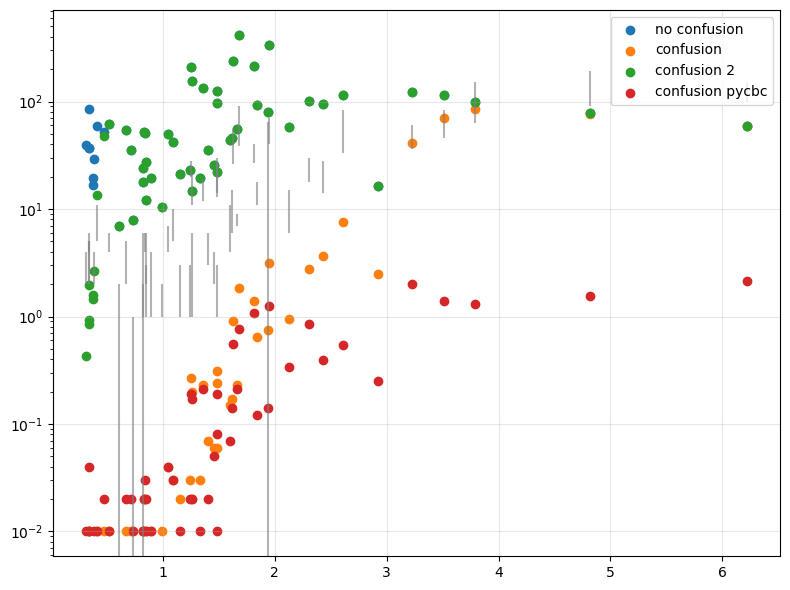

In [5]:
freqs = [d["Frequency"] for d in snr_list]
snr1 = [d["SNR"] for d in snr_list]
snr2 = [d["SNR"] for d in snr_list_gal]
snr3 = [d["SNR"] for d in snr_list_gal2]
snr4 = [d["SNR"] for d in snr_list_pycbc]



for d in snr_list:
    d["SNR predicted"] = parse_snr_range(d["SNR predicted"])


# Create figure
plt.figure(figsize=(8, 6))

# Plot SNR vs frequency for both lists
plt.scatter(freqs, snr1,  label='no confusion')
plt.scatter(freqs, snr2,  label='confusion')
plt.scatter(freqs, snr3, label='confusion 2')
plt.scatter(freqs, snr4, label='confusion pycbc')
for d in snr_list:
    f = d["Frequency"]
    smin, smax = d["SNR predicted"]
    if None not in (smin, smax):
        plt.vlines(
            f, smin, smax,
            color='gray',
            alpha=0.6,
            linewidth=1.5,
            zorder=2
        )


plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
from pycbc.psd.analytical_space import semi_analytical_psd_lisa_confusion_noise
from pycbc.psd.analytical_space import analytical_psd_lisa_tdi_AE
from library.lisa_psd import S_gal, S_gal2
from pycbc.psd.analytical_space import analytical_psd_lisa_tdi_AE_confusion
import segwo
import lisaorbits
from lisaconstants import c  # type: ignore
from pytdi.core import LISATDICombination
from pytdi.michelson import X2_ETA, Y2_ETA, Z2_ETA

# Create a static constellation with constant and equal arm lengths
orbits = lisaorbits.StaticConstellation.from_armlengths(2.5e9, 2.5e9, 2.5e9)

# Compute the positions of the spacecraft and the light travel times at t=0.0
ltts = orbits.compute_ltt(t=[0.0])
positions = orbits.compute_position(t=[0.0])


fmin = 1e-5
fmax = 0.1
df = 1e-4
fra = np.arange(fmin,  fmax, df)
#strain_cov = np.eye(2)*np.sqrt(S_gal(fra))/np.sqrt(2)
psd = noise_psd_AE_gal(fra, 2.5e9/constants.c)
psd_nog = noise_psd_AE(fra,2.5e9/constants.c)
psd2 = noise_psd_AE_gal2(fra, 2.5e9/constants.c, 4*365*24*3600)
signal_cov_eta = segwo.response.compute_isotropic_signal_cov(f, ltts, positions)
plt.loglog(fra, signal_cov_eta)
plt.loglog(fra,psd_nog, label='no confusion')
plt.loglog(fra, analytical_psd_lisa_tdi_AE_confusion(len(fra), df, fmin,tdi=1.5, duration=4), label='pycbc gal')
#plt.loglog(fra, analytical_psd_lisa_tdi_AE(len(fra), df, fmin,tdi=1.5), label ='pycbc full')
plt.loglog(fra, S_gal(fra),  label ='gal')
plt.loglog(fra, S_gal2(fra, 4*365*24*3600), label='gal2')
#plt.loglog(fra,psd, label='confusion')
#plt.loglog(fra,psd2, label='confusion 2')
plt.xlim(1e-4,1e-1)
plt.ylim(1e-47, 1e-29)
plt.legend()
plt.xscale('log')

TypeError: 'float' object is not subscriptable